# Two ways to open myplaces.kml (Google Earth) in Geopandas
Do you want to get your placesmarks from Google Earth into a geopandas GeoDataFrame? Well, you can't just call gpd.read_file() on a KML like you are used to, but it is possible if you register a fiona driver. However you'll be dissappointed if you organized your placemarks in folders and you do not want to loose this information ...

I propose an alternative way (without any additional packages) using python's minidom to get a GeoDataFrame including a column with the complete path of each placemark. KML is XML anyway ...

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from xml.dom.minidom import *
import fiona 

# Path to your myplaces.kml
url = "myplaces.kml"

## Open KML directly with geopandas and fiona driver
This is the easy and fast approach. 

In [23]:

# Register driver
gpd.io.file.fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

# Open KML
gdf = gpd.read_file(url, driver='LIBKML')

# However the first approach might not work:
gdf.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry


With the first approach however, we only get the placemarks of the base folder of myplaces. Fiona treats each folder as layer and we can iterate through these layers:

In [10]:
fiona.listlayers(url)

['Travel',
 '2021',
 '2020',
 '2019',
 'GR20',
 'Schluchtensteig',
 'Teneriffa',
 'Polen',
 '2018',
 'Tatra',
 'Schottland',
 '2017',
 'Mexiko',
 'Tschechien et al',
 'Argentinien',
 '2016',
 'Frankreich-Sardinien',
 'Normandie',
 'Philippinen',
 '2015',
 '2014',
 'Andalusien',
 'Schottland (#2)',
 '2013',
 'Everest Trek',
 'Langtang Trek',
 'Katmandu',
 'Bärentrek',
 'Toskana',
 '2012',
 'Patagonien',
 'Dolomiten HW9',
 'Kanaren',
 'Rügen',
 '2011',
 'TMB',
 'Kolumbien',
 '2010',
 'Anden',
 'Tschingelhörner',
 '2009',
 'Norwegen',
 '2008',
 'Naher Osten',
 'Kuba',
 '2007',
 'Island',
 '2006',
 'Grönland',
 '2005-4',
 'Asien',
 '2003',
 'Lengai',
 'Türkei',
 '2002',
 'Sri Lanka',
 '2001',
 'USA',
 'Santorin',
 '2000',
 'Spanien',
 'Marokko',
 'Nordnorwegen',
 '1999',
 'Home']

In [11]:
gdf_list = []
for layer in fiona.listlayers(url):
    gdf  = gpd.read_file(url, driver='LIBKML', layer=layer)
    gdf['folder'] = layer
    gdf_list.append(gdf)

gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
gdf.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry,folder
0,None,None,NaT,NaT,NaT,None,-1,0,-1,None,None,POINT Z (12.96568 47.56235 0.00000),2021
1,None,None,NaT,NaT,NaT,None,-1,0,-1,None,None,POINT Z (12.93398 47.57115 0.00000),2021
2,None,None,NaT,NaT,NaT,None,-1,0,-1,None,None,POINT Z (12.91722 47.54828 0.00000),2021
3,None,None,NaT,NaT,NaT,None,-1,0,-1,None,None,POINT Z (12.92208 47.55437 0.00000),2021
4,None,None,NaT,NaT,NaT,None,-1,0,-1,None,None,POINT Z (12.92447 47.55891 0.00000),2021


Not bad, we even added a column with the folder of the placemark. However with if you have nested folders, you loose information of the parent folders. I tried several third party python KML libraries, but it turned out easier to parse the KML myself using pythons minidom. 
## Opening KML with minidom
Minidom is one of pythons standard ways to parse XML files. I define a function to recursively get all the parent folders of each folder recursively and then I get the data for each placemark. This code is slow, but good enough for personal use.

In [13]:
dom = parse(url)

In [14]:
# Get Path with all subfolders
def subfolders(node):
    if node.parentNode == dom.documentElement:
        return ""
    else:
        foldername = node.getElementsByTagName("name")[0].firstChild.data
        path = subfolders(node.parentNode) + "/" + foldername
    return path

In [15]:
entries = []
placemarks = dom.getElementsByTagName("Placemark")

for i in placemarks:
    longitude = i.getElementsByTagName("longitude")[0].firstChild.data
    latitude = i.getElementsByTagName("latitude")[0].firstChild.data
    try:
        name = i.getElementsByTagName("name")[0].firstChild.data
    except:
        name = ""
    parent = i.parentNode
    foldername = parent.getElementsByTagName("name")[0].firstChild.data
    path = subfolders(parent) 
    entries.append((name, latitude, longitude, foldername, path)) # List of tuples

In [16]:
df = pd.DataFrame(entries, columns=('name', 'latitude', 'longitude', 'folder', 'path'))

In [17]:
df.head()

,name,latitude,longitude,folder,path
0,,47.56375461385603,12.96387472921931,2021,/Travel/2021
1,,47.58028806451221,12.93450985384602,2021,/Travel/2021
2,,47.54858854482936,12.93682985406132,2021,/Travel/2021
3,,47.5530510954143,12.92263366046039,2021,/Travel/2021
4,,47.55807437812218,12.9257558110073,2021,/Travel/2021


In [18]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))


In [19]:
gdf.head()

,name,latitude,longitude,folder,path,geometry
0,,47.56375461385603,12.96387472921931,2021,/Travel/2021,POINT (12.96387 47.56375)
1,,47.58028806451221,12.93450985384602,2021,/Travel/2021,POINT (12.93451 47.58029)
2,,47.54858854482936,12.93682985406132,2021,/Travel/2021,POINT (12.93683 47.54859)
3,,47.5530510954143,12.92263366046039,2021,/Travel/2021,POINT (12.92263 47.55305)
4,,47.55807437812218,12.9257558110073,2021,/Travel/2021,POINT (12.92576 47.55807)


In [10]:
#gdf.to_csv("myplaces.csv")

In [24]:
#gdf = gpd.read_file("myplaces.csv")

## Plots just for fun

In [20]:
natearth = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<AxesSubplot: >

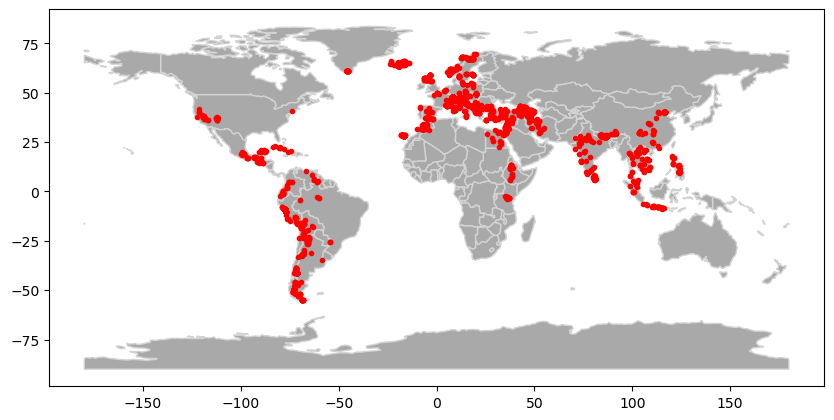

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
natearth.plot(ax=ax, color="darkgrey", edgecolor="lightgrey")
gdf.plot(ax=ax, color="red", marker=".")

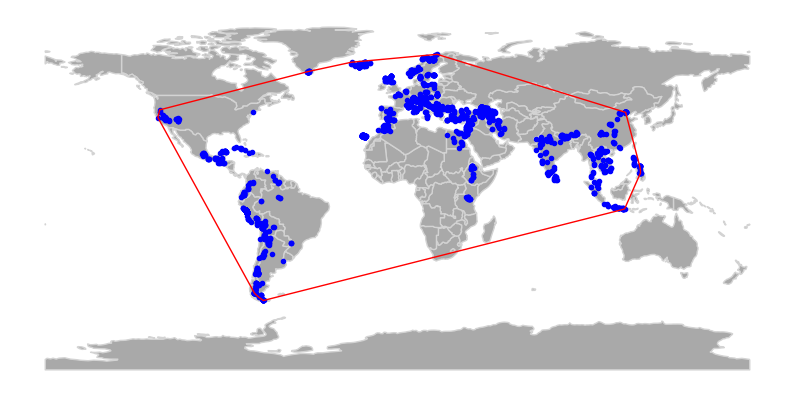

In [22]:
allpoints = gdf.dissolve()

fig, ax = plt.subplots(figsize=(10,5))
natearth.plot(ax=ax, color="darkgrey", edgecolor="lightgrey")
gdf.plot(ax=ax, color="blue", marker=".")
allpoints.convex_hull.plot(ax=ax, color="none", edgecolor="red")
ax.set_axis_off()

In [19]:
# fig.savefig("bounding-box.png")